In [1]:
import numpy as np 
import pandas as pd
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path 
import re 
import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("final_figures/figure_3")
fig_out_dir.mkdir(exist_ok=True, parents=True)

In [2]:
# ls binaural_eval/precedence_distractor_test_v02/

In [3]:
# Path to results 
# output_paths = list(Path("binaural_eval/word_task_voice_loc_cue_only_v04").glob("*.pkl")) old path for more locations
# match human pilot conditions
# model_name = 'word_task_half_co_loc_v06'
output_paths = list(Path(f"binaural_eval/precedence_distractor_test_v02/").glob("*/*v10*.pkl"))
# output_paths = list(Path(f"ls /om2/user/rphess/Auditory-Attention/binaural_eval/precedence_distractor_test/").glob("*/*.pkl"))

stim_manifest_df = pd.read_pickle('/om2/user/rphess/Auditory-Attention/final_binaural_manifest.pkl')

remap_azim = lambda azim: 360 - azim if azim > 90 else 0 - azim 

results_dfs = []

gend_map = {True:'same', False:'diff'}

for path in output_paths:
    if 'v10' not in path.stem:
        continue
    # if any([string in path.stem for string in ['v06', 'more', 'old']]):
    #     continue
    res_dict = pickle.load(open(path, 'rb'))
    df = pd.DataFrame.from_dict(res_dict)
    df.rename(columns={"results": "accuracy"}, inplace=True)
    df['model'] = path.parent.stem
    # merge with stim manifest
    df = df.join(stim_manifest_df[['word', 'bg_word','gender', 'bg_gender']], how='outer')  
    diotic =  True if 'diotic' in path.stem else False 
    df['diotic'] = diotic
    df['diotic_cond'] = None
    if 'clean' in path.stem:
        snr = 'clean'
    else:
        snr = int(re.search('(-?\d+)_SNR', path.stem).group(0).strip('_SNR'))
    df['snr'] = snr 
    if diotic:
        target_loc = path.stem.split('target_loc_')[1].split('_distract_loc_')[0].split('_')[0]
        df["target_azim"], df["target_elev"] = target_loc, target_loc
        distractor_loc = path.stem.split('_distract_loc_')[1].split('_')[0] 
        df["distractor_azim"], df["distractor_elev"] = distractor_loc, distractor_loc
        if snr == 'clean':
            df['diotic_cond'] = 'clean'
        else:
            df['diotic_cond'] = 'overlap' if target_loc == distractor_loc else distractor_loc
        df['dist_lead_channel'] = distractor_loc

    else:
        df["target_azim"], df["target_elev"] = path.stem.split('target_loc_')[1].split('_distract_loc_')[0].split('_')
        df["distractor_azim"], df["distractor_elev"] = path.stem.split('_distract_loc_')[1].split('_')[:2]
        # map azim to 0-180
        df['target_azim'] = df['target_azim'].astype(int).apply(remap_azim)
        df['distractor_azim'] = df['distractor_azim'].astype(int).apply(remap_azim)
        df['target_elev'] = df['target_elev'].astype(int)
        df['distractor_elev'] = df['distractor_elev'].astype(int)
        lead_channel = path.stem.split('_lead_')[0].split('_')[-1]
        if lead_channel == 'None':
            if (df['target_azim'].values == df['distractor_azim'].values).all():
                lead_channel = 'F-F'
            elif (df['target_azim'].values != df['distractor_azim'].values).all():
                lead_channel = 'F-R'
        else:
            if 'target_lead' in path.stem:
                # print('both simulated')
                if lead_channel == 'center':
                    lead_channel = 'FR-FR'
                elif lead_channel == 'side':
                    lead_channel = 'FR-RF'
            else:
                if lead_channel == 'center':
                    lead_channel = 'F-FR'
                elif lead_channel == 'side':
                    lead_channel = 'F-RF'
    
        df['dist_lead_channel'] = lead_channel

        
    df['gender_cond'] = df["gender"].values == df['bg_gender'].values
    df['gender_cond'] =  df['gender_cond'].map(gend_map)
    if 'clean' in path.stem:
        df['snr'] = 'clean'
    else:
        df['snr'] = int(re.search('(-?\d+)_SNR', path.stem).group(0).strip('_SNR'))
    
    results_dfs.append(df)
results = pd.concat(results_dfs)

In [4]:
# results.loc[(results.distractor_azim != 0) & (results.dist_lead_channel == "F-F")] = results[results.dist_lead_channel == "F-F"] 

In [5]:
# results[results.model == 'word_task_half_co_loc_v09_gender_bal_4M_w_no_cue_learned_higher_lr_less_dropout']

In [6]:
grouped_results = results.groupby(['model', 'target_azim', 'target_elev', 'distractor_azim','dist_lead_channel', 'diotic',
                                 'distractor_elev', 'gender_cond', 'snr']).agg({'accuracy':['mean', 'sem'],
                                                                                                                     'confusions':['mean', 'sem']}).reset_index()
# flatten multiindex
grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
# remove trailing underscore
grouped_results.columns = [col[:-1] if col[-1] == '_' else col for col in grouped_results.columns.values]


In [7]:
grouped_results.model.value_counts()

model
word_task_early_only_v10                  48
word_task_late_only_v10                   48
word_task_v10_4MGB_ln_first_arch_12       48
word_task_v10_4MGB_ln_first_arch_2        48
word_task_v10_4MGB_ln_first_arch_6        48
word_task_v10_4MGB_ln_first_arch_7        48
word_task_v10_control_no_attn             48
word_task_v10_4MGB_ln_first_arch_1        46
word_task_v10_4MGB_ln_first_arch_10       46
word_task_v10_4MGB_ln_first_arch_4        46
word_task_v10_4MGB_ln_first_arch_8        46
word_task_v10_4MGB_ln_first_arch_9        46
word_task_v10_main_feature_gain_config    46
Name: count, dtype: int64

In [8]:
print(grouped_results.groupby('model').dist_lead_channel.value_counts())

model                                   dist_lead_channel
word_task_early_only_v10                F-F                  8
                                        F-FR                 8
                                        F-R                  8
                                        F-RF                 8
                                        FR-FR                8
                                                            ..
word_task_v10_main_feature_gain_config  F-FR                 8
                                        F-R                  8
                                        F-RF                 8
                                        FR-RF                8
                                        FR-FR                6
Name: count, Length: 78, dtype: int64


In [9]:
grouped_results

,model,target_azim,target_elev,distractor_azim,dist_lead_channel,diotic,distractor_elev,gender_cond,snr,accuracy_mean,accuracy_sem,confusions_mean,confusions_sem
0,word_task_early_only_v10,0,0,-60,FR-FR,False,0,diff,-12,0.108999,0.007848,0.489227,0.012588
1,word_task_early_only_v10,0,0,-60,FR-FR,False,0,diff,-8,0.179341,0.009661,0.391635,0.012292
2,word_task_early_only_v10,0,0,-60,FR-FR,False,0,diff,-4,0.278200,0.011284,0.279468,0.011300
3,word_task_early_only_v10,0,0,-60,FR-FR,False,0,diff,0,0.387199,0.012266,0.183777,0.009753
4,word_task_early_only_v10,0,0,-60,FR-FR,False,0,same,-12,0.090621,0.007229,0.529151,0.012569
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,word_task_v10_main_feature_gain_config,0,0,60,F-RF,False,0,diff,0,0.719899,0.011308,0.011407,0.002674
608,word_task_v10_main_feature_gain_config,0,0,60,F-RF,False,0,same,-12,0.347909,0.011994,0.223067,0.010483
609,word_task_v10_main_feature_gain_config,0,0,60,F-RF,False,0,same,-8,0.474651,0.012575,0.138783,0.008706
610,word_task_v10_main_feature_gain_config,0,0,60,F-RF,False,0,same,-4,0.586185,0.012402,0.081749,0.006899


In [10]:
freyman_human_data = np.array([-11.937626695774213,73.05785123966942,
                            -7.8768127241540675,85.2892561983471,
                            -3.8259784812100452,92.23140495867769,
                            0.17838765008576019,94.54545454545455,
                            -11.99844066739436,40.826446280991746,
                            -7.911429907999382,66.94214876033058,
                            -3.8920941836893856,77.19008264462809,
                            0.09168875721191228,88.59504132231405,
                            -11.95696242008421,42.80991735537191,
                            -7.883050054576644,61.98347107438017,
                            -3.933884297520663,75.04132231404958,
                            0.15874005925463663,84.13223140495867,
                            -12.006237330422584,36.69421487603306,
                            -7.984406673943557,48.26446280991736,
                            -3.9828473413379104,49.0909090909091,
                            0.08794635895836223,66.61157024793388]).reshape(-1,2)

freyman_human_data = pd.DataFrame({'snr':freyman_human_data[:,0], 'accuracy':freyman_human_data[:,1]})
freyman_human_data['diotic_cond'] = ["F-R"] * 4 + ["F-RF"] * 4 + ["F-FR"] * 4 + ["F-F"] * 4
freyman_human_data

,snr,accuracy,diotic_cond
0,-11.937627,73.057851,F-R
1,-7.876813,85.289256,F-R
2,-3.825978,92.231405,F-R
3,0.178388,94.545455,F-R
4,-11.998441,40.826446,F-RF
5,-7.911430,66.942149,F-RF
6,-3.892094,77.190083,F-RF
7,0.091689,88.595041,F-RF
8,-11.956962,42.809917,F-FR
9,-7.883050,61.983471,F-FR


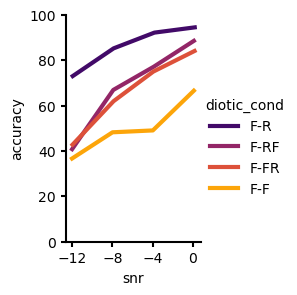

In [11]:

g = sns.relplot(data=freyman_human_data, x='snr', y='accuracy', 
            hue='diotic_cond', kind='line', palette='inferno',
            height=3, linewidth=3, aspect=0.75)
g.set(yticks=np.arange(0,  101, 20), xticks=np.arange(-12,  1, 4))
# thicken axis lines
for axis in ['bottom','left']:
    g.ax.spines[axis].set_linewidth(1.5)
# match x and y tick thickness to axes lines
g.ax.tick_params(width=1.5)

# Create model v human figure

In [12]:
freyman_grouped_results = results[results.diotic == False].groupby(['model', 'target_azim', 'distractor_azim', 'dist_lead_channel', 'gender_cond',  'snr']).agg({'accuracy':['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
# flatten multiindex
freyman_grouped_results.columns = ['_'.join(col).strip() for col in freyman_grouped_results.columns.values]
# remove trailing underscore
freyman_grouped_results.columns = [col[:-1] if col[-1] == '_' else col for col in freyman_grouped_results.columns.values]


In [13]:
freyman_grouped_results.model.unique()

array(['word_task_early_only_v10', 'word_task_late_only_v10',
       'word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_control_no_attn',
       'word_task_v10_main_feature_gain_config'], dtype=object)

In [14]:
# freyman_grouped_results[(freyman_grouped_results.model == 'word_task_standard_v07')].distractor_azim.unique()

In [15]:
# to_plot[to_plot.diotic_cond == 'overlap']

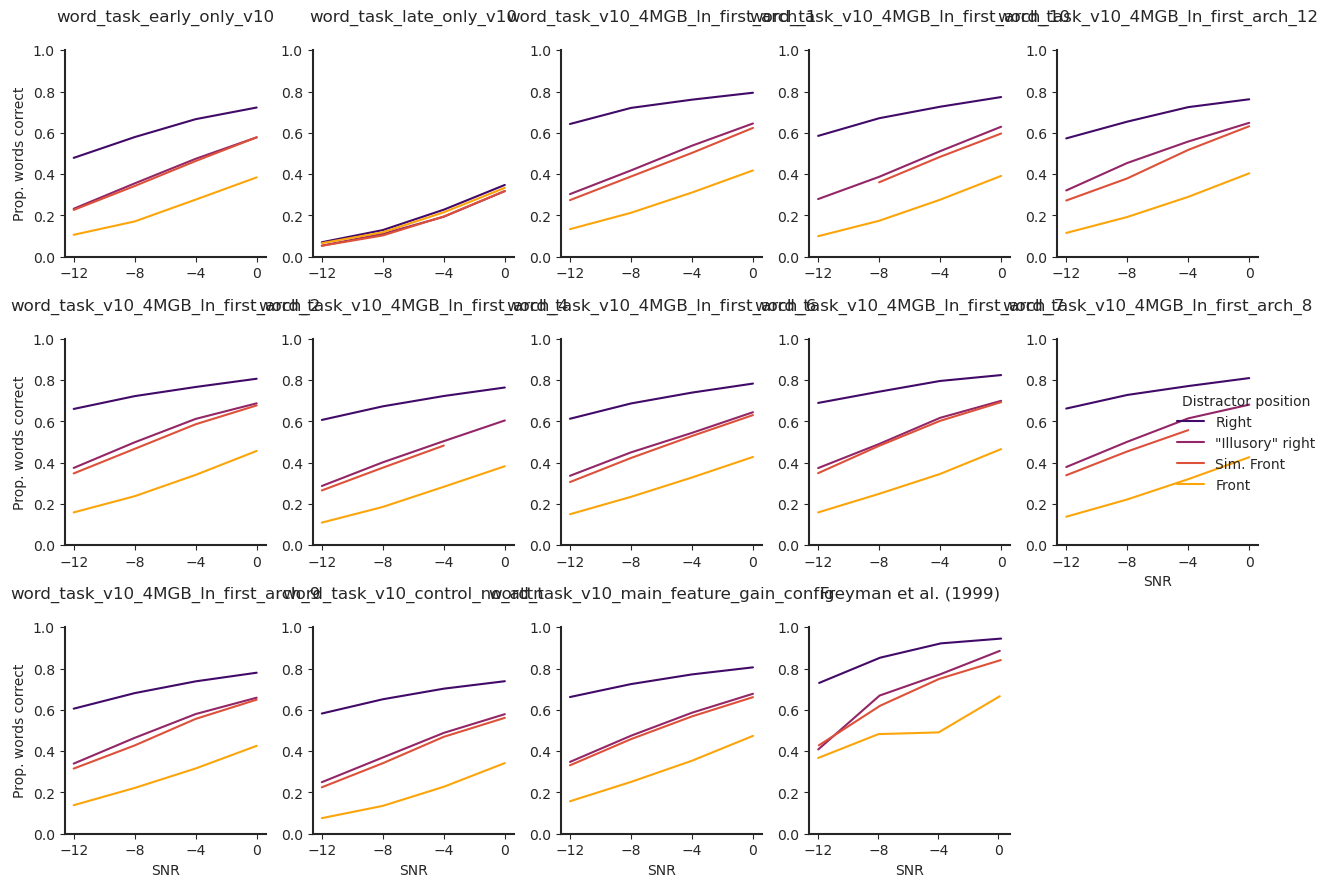

In [16]:
# hue_order = ['F-R', "F-FR", "F-RF", "FR-RF", "FR-FR", 'F-F']
hue_order = ['F-R', "F-RF", "F-FR", 'F-F']

# rename dist_lead_channel names 
name_map = {'F-R':'Right', 'F-FR':'Sim. Front', 'F-RF':'"Illusory" right', 'F-F':'Front', 'FR-RF':'Both simulated, right distractor', 'FR-FR':'Both simulated front'}
hue_order = [name_map[x] for x in hue_order]




sns.set_style('ticks')

model_to_plot = freyman_grouped_results[freyman_grouped_results.gender_cond == 'same'].copy() # freyman_grouped_results[(freyman_grouped_results.model == 'word_task_standard_v07')].copy()
model_to_plot.loc[model_to_plot.distractor_azim == 0, "distractor_azim"] = 60
# make dist location be abs 
model_to_plot['distractor_azim'] = model_to_plot['distractor_azim'].abs()

model_to_plot.loc[model_to_plot.snr == 'clean', 'snr'] = 6
model_to_plot = model_to_plot[(model_to_plot.snr.isin([-12, -8, -4, 0])) & (model_to_plot.distractor_azim == 60)]

human_to_plot = freyman_human_data.copy()


# merge model_to_plot with human data
human_to_plot['model'] = 'Freyman et al. (1999)'
human_to_plot['dist_lead_channel'] = human_to_plot['diotic_cond'] 
human_to_plot['accuracy_mean'] = human_to_plot['accuracy']/100

data_to_plot = pd.concat([model_to_plot, human_to_plot], axis=0)

data_to_plot['dist_lead_channel'] = data_to_plot['dist_lead_channel'].map(name_map)


g = sns.relplot(data=data_to_plot, x='snr', y='accuracy_mean',
             col='model', col_wrap=5, #col_order=['Freyman et al. (1999)'] + list(model_name_dict.values()),
            hue='dist_lead_channel', kind='line',# row='gender_cond',
            palette='inferno',hue_order=hue_order,
            height=3, linewidth=1.5, aspect=0.75, legend=True,
            facet_kws={'sharey': False, 'sharex': False}
)

g.set(yticks=np.arange(0,  1.1, .20), xticks=np.arange(-12,  1, 4))
# set titles
# g.set_titles("{col_name} {row_name}", size=12, y=1.1)
g.set_titles("{col_name}", size=12, y=1.1)
# set axis labels
g.set_axis_labels("SNR", "Prop. words correct")
# set legend title
g._legend.set_title("Distractor position")
# add w space
g.fig.subplots_adjust(wspace=.4)

# add x and y ticks 


# move legend closer to plot
# g._legend.set_bbox_to_anchor([0.9, 0.5])
# thicken axis lines
for ax in g.axes.flat:
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
# don't share y ticks
# plt.tight_layout()
# outfig_dest = Path('ARO_2024/figures')
plt.tight_layout()
# plt.savefig(outfig_dest/'freyman_plot.svg', transparent=True, bbox_inches='tight')

In [ ]:
to_save.to_csv

,model,target_azim,distractor_azim,dist_lead_channel,gender_cond,snr,accuracy_mean,accuracy_sem,confusions_mean,confusions_sem
0,word_task_early_only_v10,0,0,F-F,same,-12,0.106464,0.007767,0.546261,0.012537
1,word_task_early_only_v10,0,0,F-F,same,-8,0.171103,0.009483,0.435995,0.012487
2,word_task_early_only_v10,0,0,F-F,same,-4,0.276933,0.011268,0.322560,0.011771
3,word_task_early_only_v10,0,0,F-F,same,0,0.384664,0.012251,0.212928,0.010309
4,word_task_early_only_v10,0,60,F-FR,same,-12,0.226869,0.010546,0.332066,0.011859
...,...,...,...,...,...,...,...,...,...,...
199,word_task_v10_main_feature_gain_config,0,60,F-R,same,0,0.806084,0.009956,0.001267,0.000896
200,word_task_v10_main_feature_gain_config,0,60,F-RF,same,-12,0.347909,0.011994,0.223067,0.010483
201,word_task_v10_main_feature_gain_config,0,60,F-RF,same,-8,0.474651,0.012575,0.138783,0.008706
202,word_task_v10_main_feature_gain_config,0,60,F-RF,same,-4,0.586185,0.012402,0.081749,0.006899


In [17]:
## Group model results 
to_save = freyman_grouped_results[freyman_grouped_results.dist_lead_channel.isin(['F-R', 'F-RF', 'F-FR', 'F-F']) & (freyman_grouped_results.gender_cond=='same')].copy().reset_index(drop=True)
# human_to_save = freyman_human_data[freyman_human_data.diotic_cond.isin(['F-R', 'F-RF', 'F-F'])].copy().reset_index(drop=True)

## Get FBA model results

fba_models = to_save[to_save.model.str.contains('main|arch')]
# model level summary 
fba_total_summary = fba_models.groupby(['dist_lead_channel', 'snr']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem']}).reset_index()
fba_total_summary.columns =  ['dist_lead_channel', 'snr', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
fba_total_summary



# FBA model to plot 
fba_models = to_save[to_save.model.str.contains('main|arch')]
# model level summary 
fba_to_plot = fba_models.groupby(['model', 'dist_lead_channel', 'snr']).agg({'accuracy_mean':['mean', 'sem'], 'confusions_mean':['mean', 'sem']}).reset_index()
fba_to_plot.columns =  ['model', 'dist_lead_channel', 'snr', 'accuracy', 'accuracy_sem', 'confusions', 'confusions_sem']
fba_to_plot


,model,dist_lead_channel,snr,accuracy,accuracy_sem,confusions,confusions_sem
0,word_task_v10_4MGB_ln_first_arch_1,F-F,-12,0.133714,NaN,0.493029,NaN
1,word_task_v10_4MGB_ln_first_arch_1,F-F,-8,0.212928,NaN,0.385932,NaN
2,word_task_v10_4MGB_ln_first_arch_1,F-F,-4,0.311153,NaN,0.273764,NaN
3,word_task_v10_4MGB_ln_first_arch_1,F-F,0,0.418251,NaN,0.175539,NaN
4,word_task_v10_4MGB_ln_first_arch_1,F-FR,-12,0.274398,NaN,0.278200,NaN
...,...,...,...,...,...,...,...
151,word_task_v10_main_feature_gain_config,F-R,0,0.806084,NaN,0.001267,NaN
152,word_task_v10_main_feature_gain_config,F-RF,-12,0.347909,NaN,0.223067,NaN
153,word_task_v10_main_feature_gain_config,F-RF,-8,0.474651,NaN,0.138783,NaN
154,word_task_v10_main_feature_gain_config,F-RF,-4,0.586185,NaN,0.081749,NaN


In [28]:
to_save.to_csv('final_results_to_share/experiment_5_precedence_effects.csv', index=False)

### Use pingouin for stats to get effect size

In [20]:
fba_model_df.model.unique()

array(['word_task_v10_4MGB_ln_first_arch_1',
       'word_task_v10_4MGB_ln_first_arch_10',
       'word_task_v10_4MGB_ln_first_arch_12',
       'word_task_v10_4MGB_ln_first_arch_2',
       'word_task_v10_4MGB_ln_first_arch_4',
       'word_task_v10_4MGB_ln_first_arch_6',
       'word_task_v10_4MGB_ln_first_arch_7',
       'word_task_v10_4MGB_ln_first_arch_8',
       'word_task_v10_4MGB_ln_first_arch_9',
       'word_task_v10_main_feature_gain_config'], dtype=object)

In [29]:
from pingouin import rm_anova

fba_model_df = freyman_grouped_results[freyman_grouped_results.model.str.contains('main|arch') & (freyman_grouped_results.gender_cond == 'same')].copy()
fba_model_df = fba_model_df[fba_model_df.dist_lead_channel.isin(["F-RF", 'F-F'])]



rm_anova_table = rm_anova(data=fba_model_df, dv='accuracy_mean', subject='model', within=["dist_lead_channel", 'snr'], effsize='np2')
print("ANOVA for model")
rm_anova_table

ANOVA for model


/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/om2/user/imgriff/conda_envs/pytorch_2_sva/lib/python3.11/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,dist_lead_channel,1.046430,1,9,1.046430,1224.917078,6.271680e-11,6.271680e-11,0.992706,1.000000
1,snr,1.056885,3,27,0.352295,4757.049096,7.180385e-37,4.161443e-22,0.998112,0.576976
2,dist_lead_channel * snr,0.007203,3,27,0.002401,45.262331,1.146856e-10,4.941129e-07,0.834139,0.585376


In [30]:
freyman_grouped_results

,model,target_azim,distractor_azim,dist_lead_channel,gender_cond,snr,accuracy_mean,accuracy_sem,confusions_mean,confusions_sem
0,word_task_early_only_v10,0,-60,FR-FR,diff,-12,0.108999,0.007848,0.489227,0.012588
1,word_task_early_only_v10,0,-60,FR-FR,diff,-8,0.179341,0.009661,0.391635,0.012292
2,word_task_early_only_v10,0,-60,FR-FR,diff,-4,0.278200,0.011284,0.279468,0.011300
3,word_task_early_only_v10,0,-60,FR-FR,diff,0,0.387199,0.012266,0.183777,0.009753
4,word_task_early_only_v10,0,-60,FR-FR,same,-12,0.090621,0.007229,0.529151,0.012569
...,...,...,...,...,...,...,...,...,...,...
607,word_task_v10_main_feature_gain_config,0,60,F-RF,diff,0,0.719899,0.011308,0.011407,0.002674
608,word_task_v10_main_feature_gain_config,0,60,F-RF,same,-12,0.347909,0.011994,0.223067,0.010483
609,word_task_v10_main_feature_gain_config,0,60,F-RF,same,-8,0.474651,0.012575,0.138783,0.008706
610,word_task_v10_main_feature_gain_config,0,60,F-RF,same,-4,0.586185,0.012402,0.081749,0.006899


### Plot summarized model result against humans 

In [22]:
freyman_human_data

,snr,accuracy,diotic_cond
0,-11.937627,73.057851,F-R
1,-7.876813,85.289256,F-R
2,-3.825978,92.231405,F-R
3,0.178388,94.545455,F-R
4,-11.998441,40.826446,F-RF
5,-7.911430,66.942149,F-RF
6,-3.892094,77.190083,F-RF
7,0.091689,88.595041,F-RF
8,-11.956962,42.809917,F-FR
9,-7.883050,61.983471,F-FR


In [23]:
human_to_plot

,snr,accuracy,diotic_cond,model,dist_lead_channel,accuracy_mean
0,-11.937627,73.057851,F-R,Freyman et al. (1999),F-R,0.730579
1,-7.876813,85.289256,F-R,Freyman et al. (1999),F-R,0.852893
2,-3.825978,92.231405,F-R,Freyman et al. (1999),F-R,0.922314
3,0.178388,94.545455,F-R,Freyman et al. (1999),F-R,0.945455
4,-11.998441,40.826446,F-RF,Freyman et al. (1999),F-RF,0.408264
5,-7.911430,66.942149,F-RF,Freyman et al. (1999),F-RF,0.669421
6,-3.892094,77.190083,F-RF,Freyman et al. (1999),F-RF,0.771901
7,0.091689,88.595041,F-RF,Freyman et al. (1999),F-RF,0.885950
8,-11.956962,42.809917,F-FR,Freyman et al. (1999),F-FR,0.428099
9,-7.883050,61.983471,F-FR,Freyman et al. (1999),F-FR,0.619835


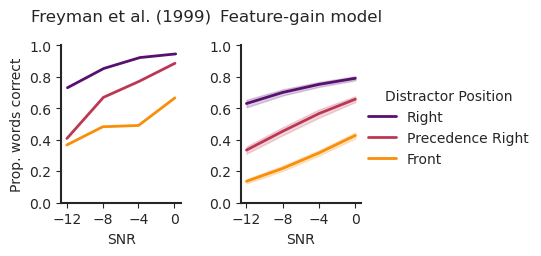

In [ ]:
# hue_order = ['F-R', "F-FR", "F-RF", "FR-RF", "FR-FR", 'F-F']
# hue_order = ['F-R',  "F-RF", "F-FR", 'F-F']
hue_order = ['F-R',  "F-RF",'F-F']

# rename dist_lead_channel names 
name_map = {'F-R':'Right', 'F-FR':'Precedence Front', 'F-RF':'Precedence Right', 'F-F':'Front', 'FR-RF':'Both simulated, right distractor', 'FR-FR':'Both simulated front'}
hue_order = [name_map[x] for x in hue_order]



sns.set_style('ticks')


model_to_plot = fba_to_plot.copy() 
model_to_plot['group'] = 'Feature-gain model'

human_to_plot = freyman_human_data.copy()

# merge model_to_plot with human data
human_to_plot['model'] = 'Freyman et al. (1999)'
human_to_plot['group'] = 'Freyman et al. (1999)'
human_to_plot['dist_lead_channel'] = human_to_plot['diotic_cond'] 
human_to_plot['accuracy'] = human_to_plot['accuracy']/100

data_to_plot = pd.concat([model_to_plot, human_to_plot], axis=0)

data_to_plot['dist_lead_channel'] = data_to_plot['dist_lead_channel'].map(name_map)


g = sns.relplot(data=data_to_plot, x='snr', y='accuracy',
            col='group', col_order=['Freyman et al. (1999)', 'Feature-gain model'],
            hue='dist_lead_channel', kind='line',
            palette='inferno',hue_order=hue_order,
            errorbar=('se', 2),
            height=2.5, linewidth=2, aspect=0.8, legend=True,
            facet_kws={'sharey': False, 'sharex': False}
)

g.set(yticks=np.arange(0,  1.1, .20), xticks=np.arange(-12,  1, 4))
# set titles
g.set_titles("{col_name}", size=12, y=1.1)
# set axis labels
g.set_axis_labels("SNR", "Prop. words correct")
# set legend title
g._legend.set_title("Distractor Position")
# add w space
g.fig.subplots_adjust(wspace=.5)

# add x and y ticks 


# move legend closer to plot
# g._legend.set_bbox_to_anchor([0.9, 0.5])
# thicken axis lines
for ax in g.axes.flat:
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)
# don't share y ticks
# plt.tight_layout()
# plt.tight_layout()
# plt.savefig(outfig_dest/'freyman_plot.svg', transparent=True, bbox_inches='tight')
# plt.savefig(fig_out_dir/'human_v_model_precedence.pdf', transparent=True, bbox_inches='tight')
